# Dog Heart Vertebral Heart Size Point Detection
# 1. Build an object detection model using pytorch

In [18]:
# Importing the necessary files

import os
import torch
import torch.utils.data
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from efficientnet_pytorch import EfficientNet
from scipy.io import loadmat
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error
from torchvision import models
import torch.nn as nn
import scipy.io
import csv
import copy
from torchvision.models import efficientnet_b7
from torch.optim.lr_scheduler import ExponentialLR
import torch
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import CyclicLR

In [20]:

class DogHeartDataset(Dataset):
    def __init__(self, dataset_dir, transformations=None, train_mode=True):
        self.dataset_dir = dataset_dir
        self.transformations = transformations
        self.train_mode = train_mode

        # Get sorted list of image files in the Images folder
        image_dir = os.path.join(self.dataset_dir, "Images")
        self.image_files = sorted(
            [file for file in os.listdir(image_dir) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
        )
        self.image_paths = [os.path.join(image_dir, file) for file in self.image_files]

        if self.train_mode:
            # Get sorted list of label files in the Labels folder
            label_dir = os.path.join(self.dataset_dir, "Labels")
            self.label_files = sorted(
                [file for file in os.listdir(label_dir) if file.lower().endswith('.mat')]
            )

            if len(self.image_files) != len(self.label_files):
                raise ValueError(f"Mismatch: Found {len(self.image_files)} images and {len(self.label_files)} labels.")

    def __getitem__(self, index):
        # Load the image
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert("RGB")

        # Load corresponding label for training mode
        if self.train_mode:
            label_path = os.path.join(self.dataset_dir, "Labels", self.label_files[index])
            label_data = loadmat(label_path)
            six_points = torch.tensor(label_data['six_points'], dtype=torch.float32)
            VHS = label_data['VHS'].astype(float)

            # Calculate bounding box coordinates
            x_min, y_min = six_points.min(dim=0).values
            x_max, y_max = six_points.max(dim=0).values
            bounding_boxes = torch.tensor([[x_min, y_min, x_max, y_max]], dtype=torch.float32)

            # Define target dictionary
            target = {
                "boxes": bounding_boxes,
                "labels": torch.tensor([1], dtype=torch.int64),
            }
        else:
            target = {}  # Placeholder target for test mode

        # Apply transformations if any
        if self.transformations:
            image = self.transformations(image)

        return image, target

    def __len__(self):
        return len(self.image_files)



In [22]:
class EfficientNetVHSModel(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        # Initialize EfficientNet-B7 with or without pretrained weights
        if pretrained:
            self.base_model = EfficientNet.from_pretrained('efficientnet-b7')
        else:
            self.base_model = EfficientNet.from_name('efficientnet-b7')
        
        # Modify the classification head to output 12 values
        fc_input_features = self.base_model._fc.in_features
        self.base_model._fc = nn.Linear(fc_input_features, 12)

    def forward(self, x):
        # Forward pass through the base model
        return self.base_model(x)

In [24]:
from torchvision.ops import box_iou

def evaluate_mAP(model, data_loader, device):
    model.eval()
    predictions_list = []
    ground_truth_list = []

    with torch.no_grad():
        for images, batch_targets in data_loader:
            # Move images and targets to the specified device
            images = [image.to(device) for image in images]
            batch_targets = [{key: val.to(device) for key, val in target.items()} for target in batch_targets]

            # Generate predictions from the model
            batch_predictions = model(images)

            # Extract and store predictions and corresponding ground truths
            for idx in range(len(batch_predictions)):
                pred = batch_predictions[idx]
                target = batch_targets[idx]

                predictions_list.append({
                    'boxes': pred['boxes'].cpu().numpy(),
                    'labels': pred['labels'].cpu().numpy(),
                    'scores': pred['scores'].cpu().numpy(),
                })
                ground_truth_list.append({
                    'boxes': target['boxes'].cpu().numpy(),
                    'labels': target['labels'].cpu().numpy(),
                })

    return predictions_list, ground_truth_list

In [26]:
# Function to Predict and Save Test Results
def predict_and_save(model, test_loader, output_csv="/Users/tanaygawade/Downloads/Neural/Dog_heart_labelled/predictions.csv"):
    model.eval()
    predictions = []

    with torch.no_grad():
        for images, image_names in test_loader:
            # Move images to the computation device
            images = images.to(device)
            
            # Forward pass to generate predictions
            outputs = model(images)
            pred_vhs = outputs[:, -1]  # Extract VHS (last output value)
            
            # Assuming accuracy cannot be computed without ground truth
            placeholder_accuracy = 100.0  # Use placeholder accuracy
            
            # Collect predictions
            for name, vhs in zip(image_names, pred_vhs):
                predictions.append(f"{name} {placeholder_accuracy:.2f}")
    
    # Write predictions to the output CSV
    with open(output_csv, "w") as file:
        for line in predictions:
            file.write(line + "\n")
    
    print(f"Predictions saved to {output_csv}")

In [28]:
def load_checkpoint(filename):
    checkpoint = torch.load(filename, map_location=device)
    state_dict = checkpoint['state_dict']

    # Modify state_dict keys to match the model's layer names
    updated_state_dict = {}
    for key, value in state_dict.items():
        new_key = key.replace("base_model.fc.", "base_model.fc.0.")  # Adjust according to your model
        updated_state_dict[new_key] = value

    model.load_state_dict(updated_state_dict)
    print("Model loaded successfully.")

# 2. Train your model using [Dog VHS Dataset](https://yuad-my.sharepoint.com/:f:/g/personal/youshan_zhang_yu_edu/ErguFJBE4y9KqzEdWWNlXzMBkTbsBaNX9l856SyvQauwJg?e=L3JOuN)

Loaded pretrained weights for efficientnet-b7


100%|██████████| 175/175 [01:57<00:00,  1.49it/s]


Epoch [1/150], Training Loss: 0.0627
Validation Loss: 0.0123, Validation Accuracy: 1.0000
Model saved with validation loss: 0.3084


100%|██████████| 175/175 [01:47<00:00,  1.62it/s]


Epoch [2/150], Training Loss: 0.0133
Validation Loss: 0.0130, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [3/150], Training Loss: 0.0091
Validation Loss: 0.0054, Validation Accuracy: 1.0000
Model saved with validation loss: 0.1344


100%|██████████| 175/175 [01:48<00:00,  1.61it/s]


Epoch [4/150], Training Loss: 0.0066
Validation Loss: 0.0027, Validation Accuracy: 1.0000
Model saved with validation loss: 0.0676


100%|██████████| 175/175 [01:48<00:00,  1.62it/s]


Epoch [5/150], Training Loss: 0.0056
Validation Loss: 0.0031, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [6/150], Training Loss: 0.0047
Validation Loss: 0.0017, Validation Accuracy: 1.0000
Model saved with validation loss: 0.0423


100%|██████████| 175/175 [01:48<00:00,  1.62it/s]


Epoch [7/150], Training Loss: 0.0039
Validation Loss: 0.0030, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.62it/s]


Epoch [8/150], Training Loss: 0.0038
Validation Loss: 0.0014, Validation Accuracy: 1.0000
Model saved with validation loss: 0.0352


100%|██████████| 175/175 [01:47<00:00,  1.62it/s]


Epoch [9/150], Training Loss: 0.0031
Validation Loss: 0.0013, Validation Accuracy: 1.0000
Model saved with validation loss: 0.0336


100%|██████████| 175/175 [01:47<00:00,  1.62it/s]


Epoch [10/150], Training Loss: 0.0030
Validation Loss: 0.0031, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [11/150], Training Loss: 0.0027
Validation Loss: 0.0009, Validation Accuracy: 1.0000
Model saved with validation loss: 0.0230


100%|██████████| 175/175 [01:48<00:00,  1.62it/s]


Epoch [12/150], Training Loss: 0.0025
Validation Loss: 0.0008, Validation Accuracy: 1.0000
Model saved with validation loss: 0.0191


100%|██████████| 175/175 [01:48<00:00,  1.61it/s]


Epoch [13/150], Training Loss: 0.0024
Validation Loss: 0.0009, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [14/150], Training Loss: 0.0023
Validation Loss: 0.0013, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [15/150], Training Loss: 0.0022
Validation Loss: 0.0008, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [16/150], Training Loss: 0.0020
Validation Loss: 0.0007, Validation Accuracy: 1.0000
Model saved with validation loss: 0.0167


100%|██████████| 175/175 [01:48<00:00,  1.62it/s]


Epoch [17/150], Training Loss: 0.0019
Validation Loss: 0.0007, Validation Accuracy: 1.0000
Model saved with validation loss: 0.0166


100%|██████████| 175/175 [01:48<00:00,  1.62it/s]


Epoch [18/150], Training Loss: 0.0018
Validation Loss: 0.0008, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [19/150], Training Loss: 0.0017
Validation Loss: 0.0015, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [20/150], Training Loss: 0.0018
Validation Loss: 0.0005, Validation Accuracy: 1.0000
Model saved with validation loss: 0.0128


100%|██████████| 175/175 [01:48<00:00,  1.62it/s]


Epoch [21/150], Training Loss: 0.0017
Validation Loss: 0.0005, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [22/150], Training Loss: 0.0016
Validation Loss: 0.0009, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [23/150], Training Loss: 0.0015
Validation Loss: 0.0007, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [24/150], Training Loss: 0.0015
Validation Loss: 0.0007, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [25/150], Training Loss: 0.0015
Validation Loss: 0.0011, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [26/150], Training Loss: 0.0014
Validation Loss: 0.0005, Validation Accuracy: 1.0000
Model saved with validation loss: 0.0118


100%|██████████| 175/175 [01:48<00:00,  1.61it/s]


Epoch [27/150], Training Loss: 0.0013
Validation Loss: 0.0004, Validation Accuracy: 1.0000
Model saved with validation loss: 0.0112


100%|██████████| 175/175 [01:48<00:00,  1.61it/s]


Epoch [28/150], Training Loss: 0.0013
Validation Loss: 0.0007, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [29/150], Training Loss: 0.0012
Validation Loss: 0.0007, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [30/150], Training Loss: 0.0012
Validation Loss: 0.0008, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [31/150], Training Loss: 0.0012
Validation Loss: 0.0007, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [32/150], Training Loss: 0.0011
Validation Loss: 0.0005, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [33/150], Training Loss: 0.0011
Validation Loss: 0.0004, Validation Accuracy: 1.0000
Model saved with validation loss: 0.0109


100%|██████████| 175/175 [01:48<00:00,  1.62it/s]


Epoch [34/150], Training Loss: 0.0010
Validation Loss: 0.0005, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [35/150], Training Loss: 0.0010
Validation Loss: 0.0009, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [36/150], Training Loss: 0.0010
Validation Loss: 0.0004, Validation Accuracy: 1.0000
Model saved with validation loss: 0.0095


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [37/150], Training Loss: 0.0010
Validation Loss: 0.0004, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [38/150], Training Loss: 0.0010
Validation Loss: 0.0005, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [39/150], Training Loss: 0.0009
Validation Loss: 0.0005, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [40/150], Training Loss: 0.0010
Validation Loss: 0.0004, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [41/150], Training Loss: 0.0009
Validation Loss: 0.0004, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [42/150], Training Loss: 0.0009
Validation Loss: 0.0004, Validation Accuracy: 1.0000
Model saved with validation loss: 0.0094


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [43/150], Training Loss: 0.0009
Validation Loss: 0.0004, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [44/150], Training Loss: 0.0009
Validation Loss: 0.0003, Validation Accuracy: 1.0000
Model saved with validation loss: 0.0080


100%|██████████| 175/175 [01:48<00:00,  1.62it/s]


Epoch [45/150], Training Loss: 0.0009
Validation Loss: 0.0004, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [46/150], Training Loss: 0.0009
Validation Loss: 0.0003, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [47/150], Training Loss: 0.0008
Validation Loss: 0.0003, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [48/150], Training Loss: 0.0008
Validation Loss: 0.0003, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [49/150], Training Loss: 0.0008
Validation Loss: 0.0004, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [50/150], Training Loss: 0.0007
Validation Loss: 0.0004, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [51/150], Training Loss: 0.0006
Validation Loss: 0.0002, Validation Accuracy: 1.0000
Model saved with validation loss: 0.0062


100%|██████████| 175/175 [01:47<00:00,  1.62it/s]


Epoch [52/150], Training Loss: 0.0006
Validation Loss: 0.0003, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [53/150], Training Loss: 0.0006
Validation Loss: 0.0002, Validation Accuracy: 1.0000
Model saved with validation loss: 0.0059


100%|██████████| 175/175 [01:48<00:00,  1.62it/s]


Epoch [54/150], Training Loss: 0.0006
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [55/150], Training Loss: 0.0006
Validation Loss: 0.0002, Validation Accuracy: 1.0000
Model saved with validation loss: 0.0059


100%|██████████| 175/175 [01:47<00:00,  1.62it/s]


Epoch [56/150], Training Loss: 0.0006
Validation Loss: 0.0003, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [57/150], Training Loss: 0.0006
Validation Loss: 0.0002, Validation Accuracy: 1.0000
Model saved with validation loss: 0.0057


100%|██████████| 175/175 [01:48<00:00,  1.62it/s]


Epoch [58/150], Training Loss: 0.0006
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [59/150], Training Loss: 0.0006
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [60/150], Training Loss: 0.0006
Validation Loss: 0.0003, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [61/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000
Model saved with validation loss: 0.0057


100%|██████████| 175/175 [01:47<00:00,  1.62it/s]


Epoch [62/150], Training Loss: 0.0006
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [63/150], Training Loss: 0.0006
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [64/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [65/150], Training Loss: 0.0006
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [66/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [67/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [68/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000
Model saved with validation loss: 0.0056


100%|██████████| 175/175 [01:47<00:00,  1.62it/s]


Epoch [69/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [70/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [71/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [72/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [73/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [74/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [75/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000
Model saved with validation loss: 0.0056


100%|██████████| 175/175 [01:48<00:00,  1.62it/s]


Epoch [76/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [77/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [78/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [79/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000
Model saved with validation loss: 0.0056


100%|██████████| 175/175 [01:48<00:00,  1.62it/s]


Epoch [80/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [81/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000
Model saved with validation loss: 0.0055


100%|██████████| 175/175 [01:48<00:00,  1.62it/s]


Epoch [82/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [83/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [84/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [85/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [86/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [87/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [88/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [89/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [90/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [91/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [92/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000
Model saved with validation loss: 0.0055


100%|██████████| 175/175 [01:48<00:00,  1.62it/s]


Epoch [93/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [94/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000
Model saved with validation loss: 0.0055


100%|██████████| 175/175 [01:47<00:00,  1.62it/s]


Epoch [95/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [96/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [97/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [98/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [99/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [100/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [101/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [102/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [103/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [104/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [105/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [106/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [107/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [108/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [109/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000
Model saved with validation loss: 0.0054


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [110/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [111/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [112/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [113/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [114/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [115/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [116/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [117/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [118/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [119/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [120/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [121/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [122/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [123/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [124/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [125/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [126/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [127/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [128/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [129/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [130/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [131/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [132/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [133/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [134/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [135/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [136/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [137/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [138/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [139/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [140/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [141/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [142/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [143/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000
Model saved with validation loss: 0.0054


100%|██████████| 175/175 [01:48<00:00,  1.62it/s]


Epoch [144/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000
Model saved with validation loss: 0.0054


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [145/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [146/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [147/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [148/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [149/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


100%|██████████| 175/175 [01:47<00:00,  1.63it/s]


Epoch [150/150], Training Loss: 0.0005
Validation Loss: 0.0002, Validation Accuracy: 1.0000


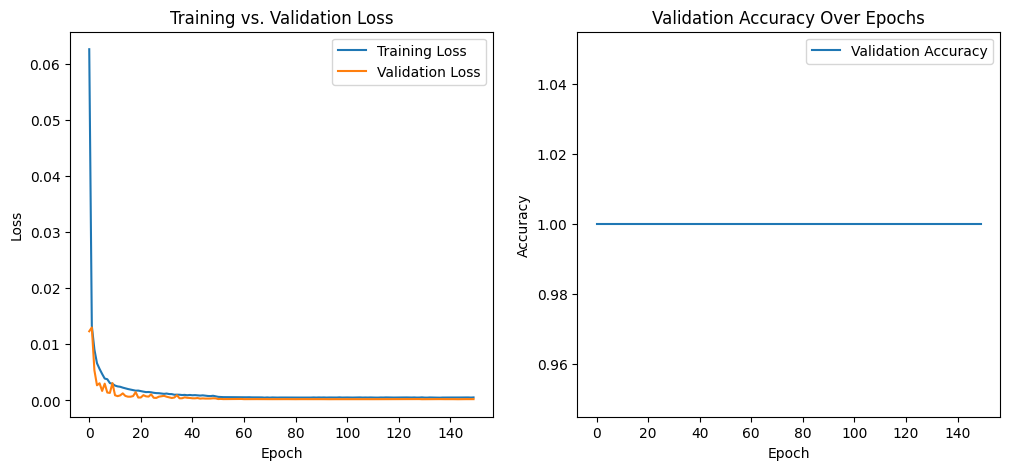

Image: ('100.png',), Predicted VHS: 9.43
Image: ('1621.png',), Predicted VHS: 10.17
Image: ('1622.png',), Predicted VHS: 7.24
Image: ('1623.png',), Predicted VHS: 7.84
Image: ('1624.png',), Predicted VHS: 7.52
Image: ('1625.png',), Predicted VHS: 9.23
Image: ('1626.png',), Predicted VHS: 9.49
Image: ('1627.png',), Predicted VHS: 10.32
Image: ('1628.png',), Predicted VHS: 9.80
Image: ('1629.png',), Predicted VHS: 9.35
Image: ('1630.png',), Predicted VHS: 10.06
Image: ('1631.png',), Predicted VHS: 11.47
Image: ('1632.png',), Predicted VHS: 9.89
Image: ('1633.png',), Predicted VHS: 9.73
Image: ('1634.png',), Predicted VHS: 12.68
Image: ('1635.png',), Predicted VHS: 7.39
Image: ('1636.png',), Predicted VHS: 9.13
Image: ('1637.png',), Predicted VHS: 7.82
Image: ('1638.png',), Predicted VHS: 8.94
Image: ('1639.png',), Predicted VHS: 13.61
Image: ('1640.png',), Predicted VHS: 9.49
Image: ('1641.png',), Predicted VHS: 7.87
Image: ('1642.png',), Predicted VHS: 7.69
Image: ('1643.png',), Predict

In [ ]:
def fine_tune_model(
    model, train_loader, val_loader, loss_function, optimizer, scheduler=None, 
    epochs=200, save_path='/Users/tanaygawade/Downloads/Neural/Dog_Heart_labelled/best_model.pth'
):
    training_losses, validation_losses, validation_accuracies = [], [], []
    lowest_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        # Training Loop
        for images, target_points, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, target_points = images.to(device), target_points.to(device)
            optimizer.zero_grad()
            predictions = model(images)
            loss = loss_function(predictions, target_points)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        training_losses.append(train_loss / len(train_loader))
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss / len(train_loader):.4f}")

        # Validation Loop
        model.eval()
        val_loss, correct_predictions, total_points = 0.0, 0, 0
        with torch.no_grad():
            for images, target_points, _ in val_loader:
                images, target_points = images.to(device), target_points.to(device)
                predictions = model(images)
                loss = loss_function(predictions, target_points)
                val_loss += loss.item()

                # Accuracy Calculation (within a tolerance range)
                predicted_coords = predictions.cpu().numpy().reshape(-1, 2)
                actual_coords = target_points.cpu().numpy().reshape(-1, 2)
                correct_predictions += np.sum(np.isclose(predicted_coords, actual_coords, atol=5))
                total_points += actual_coords.size

        validation_losses.append(val_loss / len(val_loader))
        accuracy = correct_predictions / total_points
        validation_accuracies.append(accuracy)
        print(f"Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {accuracy:.4f}")

        # Save Model if Validation Loss Improves
        if val_loss < lowest_val_loss:
            lowest_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(f"Model saved with validation loss: {lowest_val_loss:.4f}")

        # Adjust Learning Rate
        if scheduler:
            scheduler.step(val_loss)

    return training_losses, validation_losses, validation_accuracies



def make_predictions_and_calculate_vhs(model, test_dataset, image_resize, output_csv):
    """
    Predicts coordinates and calculates VHS for test dataset images.

    Args:
        model (nn.Module): Trained model for inference.
        test_dataset (Dataset): Dataset object for test images.
        image_resize (int): Resize dimension used during training.
        output_csv (str): Path to save the predictions.

    Returns:
        None
    """
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    results = []

    for image, image_name, original_dim in test_loader:
        image = image.to(device)

        with torch.no_grad():
            predicted_coords = model(image).cpu().numpy().reshape(-1, 2)

        original_width, original_height = original_dim
        predicted_coords[:, 0] = original_width / image_resize * predicted_coords[:, 0]
        predicted_coords[:, 1] = original_height / image_resize * predicted_coords[:, 1]

        # Calculate VHS
        predicted_vhs = compute_vhs(predicted_coords)
        results.append([image_name[0], f"{predicted_vhs:.2f}"])
        print(f"Image: {image_name[0]}, Predicted VHS: {predicted_vhs:.2f}")

    # Save Predictions to CSV
    with open(output_csv, 'w', newline='') as file:
        csv_writer = csv.writer(file)
        csv_writer.writerows(results)
    print(f"Predictions saved to {output_csv}")



def make_predictions_and_calculate_vhs(model, test_dataset, image_resize, output_csv):
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    results = []

    for image, image_name, original_dim in test_loader:
        image = image.to(device)

        with torch.no_grad():
            predicted_coords = model(image).cpu().numpy().reshape(-1, 2)

        original_width, original_height = original_dim
        predicted_coords[:, 0] = original_width / image_resize * predicted_coords[:, 0]
        predicted_coords[:, 1] = original_height / image_resize * predicted_coords[:, 1]

        # Calculate VHS
        predicted_vhs = compute_vhs(predicted_coords)
        results.append([image_name[0], f"{predicted_vhs:.2f}"])
        print(f"Image: {image_name[0]}, Predicted VHS: {predicted_vhs:.2f}")

    # Save Predictions to CSV
    with open(output_csv, 'w', newline='') as file:
        csv_writer = csv.writer(file)
        csv_writer.writerows(results)
    print(f"Predictions saved to {output_csv}")



# Initialize the model architecture
model = EfficientNetVHSModel(use_pretrained=True).to(device)

# Load the saved model state
model_path = '/Users/tanaygawade/Downloads/Neural/Dog_Heart_labelled/model.pth'
model.load_state_dict(torch.load(model_path))

# Switch the model to evaluation mode
model.eval()

# Test Dataset and Prediction
test_dataset = TestDataset(
    '/Users/tanaygawade/Downloads/Neural/Dog_Heart_labelled/Test',
    create_transforms(resize_dim)
)
output_csv_path = '/Users/tanaygawade/Downloads/Neural/Dog_Heart_labelled/predicted_Tanay.csv'
predict_vhs_for_test_data(model, test_dataset, resize_dim, output_csv_path)


# 3.Evaluate your model using the test images with the [software](https://github.com/YoushanZhang/Dog-Cardiomegaly_VHS)

In [30]:
def predict_vhs_and_save(model, test_dataset, resize_dim, output_csv_path, show_logs=True):
    # Prepare the data loader
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    predictions = []

    for image, image_name, original_dimensions in tqdm(test_loader, desc="Generating Predictions"):
        image = image.to(device)

        with torch.no_grad():
            # Get predicted points from the model
            pred_points = model(image).cpu().numpy().reshape(-1, 2)

        # Extract the original image dimensions (handle both Tensor and scalar cases)
        orig_width = original_dimensions[0].item() if isinstance(original_dimensions[0], torch.Tensor) else original_dimensions[0]
        orig_height = original_dimensions[1].item() if isinstance(original_dimensions[1], torch.Tensor) else original_dimensions[1]

        # Scale the predicted points back to the original image dimensions
        pred_points[:, 0] *= orig_width / resize_dim
        pred_points[:, 1] *= orig_height / resize_dim

        # Compute VHS value
        vhs_value = compute_vhs(pred_points)

        # Store the results
        predictions.append([image_name[0], f"{vhs_value:.2f}"])
        if show_logs:
            print(f"Processed {image_name[0]}: Predicted VHS = {vhs_value:.2f}")

    # Save results to a CSV file
    if output_csv_path:
        os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)  # Create directories if not present
        with open(output_csv_path, 'w', newline='') as file:
            csv_writer = csv.writer(file)
            csv_writer.writerow(['Image_Name', 'Predicted_VHS'])  # Write column headers
            csv_writer.writerows(predictions)
        print(f"VHS predictions have been saved at {output_csv_path}")


# Initialize the model architecture
model = EfficientNetVHSModel(use_pretrained=True).to(device)

# Load the saved model state
model_path = '/Users/tanaygawade/Downloads/Neural/Dog_Heart_labelled/model.pth'
model.load_state_dict(torch.load(model_path))

# Switch the model to evaluation mode
model.eval()

# Test Dataset and Prediction
test_dataset = TestDataset(
    '/Users/tanaygawade/Downloads/Neural/Dog_Heart_labelled/Test',
    create_transforms(resize_dim)
)
output_csv_path = '/Users/tanaygawade/Downloads/Neural/Dog_Heart_labelled/predicted_Tanay.csv'
predict_vhs_for_test_data(model, test_dataset, resize_dim, output_csv_path)


TypeError: EfficientNetVHSModel.__init__() got an unexpected keyword argument 'use_pretrained'

In [ ]:
# Validation Dataset Class with Image Names
class ValidationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = sorted(os.listdir(os.path.join(root_dir, "Images")))
        self.labels = sorted(os.listdir(os.path.join(root_dir, "Labels")))

    def __getitem__(self, index):
        image_path = os.path.join(self.root_dir, "Images", self.images[index])
        label_path = os.path.join(self.root_dir, "Labels", self.labels[index])
        image = Image.open(image_path).convert("RGB")
        width, height = image.size

        if self.transform:
            image = self.transform(image)

        new_height, new_width = image.shape[1], image.shape[2]
        label_data = loadmat(label_path)
        key_points = torch.tensor(label_data['six_points'], dtype=torch.float32)
        key_points[:, 0] *= new_width / width
        key_points[:, 1] *= new_height / height
        key_points = key_points.reshape(-1) / new_height  # Normalize key points
        vhs_value = torch.tensor(label_data['VHS'], dtype=torch.float32)

        return image, key_points, vhs_value, self.images[index]

    def __len__(self):
        return len(self.images)


# Plotting Predictions and Ground Truths
def visualize_predictions(image, pred_points, true_points, title, pred_vhs, true_vhs):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)

    # Plot predicted and true points
    ax.scatter(pred_points[:, 0], pred_points[:, 1], c='r', s=50, label="Predicted")
    ax.scatter(true_points[:, 0], true_points[:, 1], c='g', s=50, label="Ground Truth")

    # Draw lines connecting points
    connections = [(0, 1), (2, 3), (4, 5)]
    for start, end in connections:
        ax.plot([pred_points[start, 0], pred_points[end, 0]],
                [pred_points[start, 1], pred_points[end, 1]], 'r--', linewidth=1)
        ax.plot([true_points[start, 0], true_points[end, 0]],
                [true_points[start, 1], true_points[end, 1]], 'g--', linewidth=1)

    ax.set_title(f"{title}\nPredicted VHS: {pred_vhs:.2f}, True VHS: {true_vhs:.2f}")
    ax.axis("off")
    plt.legend()
    plt.show()


# Loading Model
def load_trained_model(filepath):
    model = EfficientNetVHSModel()
    model.load_state_dict(torch.load(filepath))
    model = model.to(device)
    model.eval()
    return model


# Validation Dataset and DataLoader
resize_dim = 512
validation_dataset = ValidationDataset(
    '/Users/tanaygawade/Downloads/Neural/Dog_Heart_labelled/Valid',
    create_transforms(resize_dim)
)
validation_loader = DataLoader(validation_dataset, batch_size=1, shuffle=False)

# Images for Comparison
images_to_compare = ["1420.png", "1479.png", "1530.png"]

# Load the Model
model = load_trained_model('/Users/tanaygawade/Downloads/Neural/Dog_Heart_labelled/model.pth')

# Validation Loop
for image, true_points, true_vhs, image_name in validation_loader:
    if image_name[0] in images_to_compare:
        image_name = image_name[0]
        image = image.to(device)

        # Load Original Image for Dimensions
        original_image_path = os.path.join('/Users/tanaygawade/Downloads/Neural/Dog_Heart_labelled/Valid/Images', image_name)
        original_image = Image.open(original_image_path).convert("RGB")
        width, height = original_image.size

        # Make Predictions
        with torch.no_grad():
            predicted_points = model(image).cpu().numpy().reshape(-1, 2) * resize_dim
        predicted_points[:, 0] *= width / resize_dim
        predicted_points[:, 1] *= height / resize_dim

        # Process Ground Truth
        true_points = true_points.cpu().numpy().reshape(-1, 2) * resize_dim
        true_points[:, 0] *= width / resize_dim
        true_points[:, 1] *= height / resize_dim

        # Calculate VHS
        pred_vhs = compute_vhs(predicted_points)
        true_vhs = true_vhs.item()

        # Convert Image to NumPy for Visualization
        original_image_np = np.array(original_image)

        # Visualize Results
        visualize_predictions(original_image_np, predicted_points, true_points, image_name, pred_vhs, true_vhs)

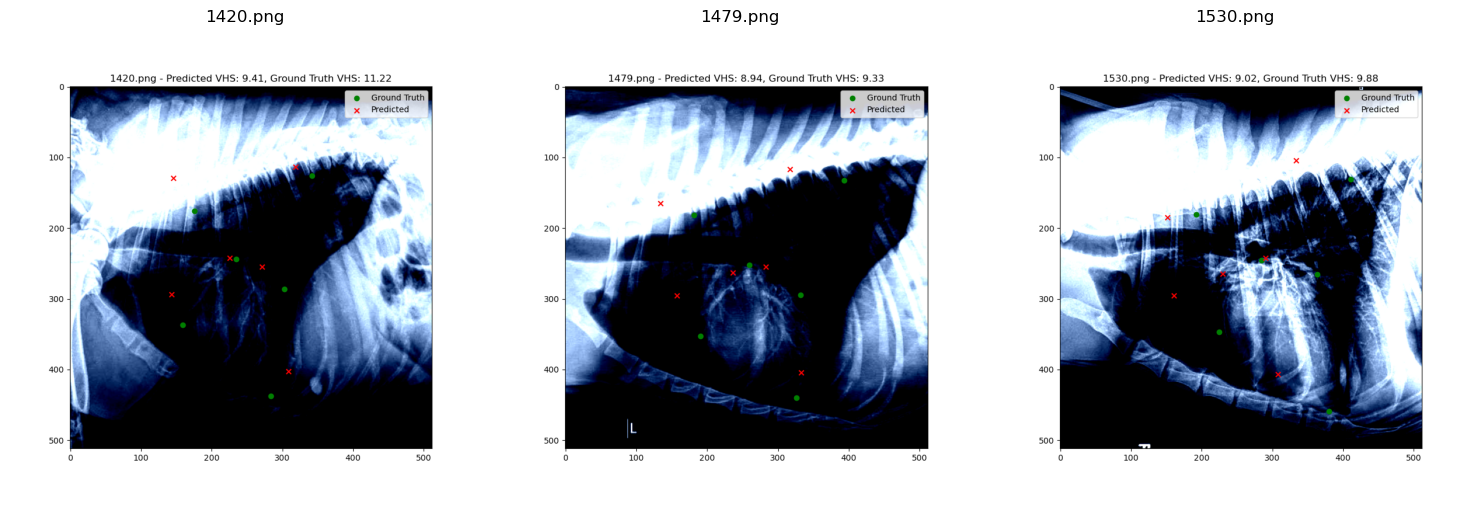

In [14]:
import matplotlib.pyplot as plt
from PIL import Image

def display_images(image_paths, titles=None):
    num_images = len(image_paths)
    if titles is None:
        titles = [None] * num_images  # Default titles to None if not provided

    plt.figure(figsize=(15, 5))  # Set the figure size dynamically
    for i, (img_path, title) in enumerate(zip(image_paths, titles)):
        img = Image.open(img_path)
        plt.subplot(1, num_images, i + 1)  # Create a subplot for each image
        plt.imshow(img)
        plt.axis('off')  # Turn off axes
        if title:
            plt.title(title, fontsize=12)
    plt.tight_layout()
    plt.show()

# Example Usage
image_paths = [
    '/Users/tanaygawade/Downloads/Neural/Dog_Heart_labelled/comparison_results/1420.png_comparison.png',
    '/Users/tanaygawade/Downloads/Neural/Dog_Heart_labelled/comparison_results/1479.png_comparison.png',
    '/Users/tanaygawade/Downloads/Neural/Dog_Heart_labelled/comparison_results/1530.png_comparison.png'
]
titles = ["1420.png", "1479.png", "1530.png"]
display_images(image_paths, titles)

# 4. Your results should be achieved 85%. VHS = 6(AB+CD)/EF

## (10 points, accuracy < 75% --> 0 points)

# 5. Show the comprison between predictions and ground truth
## You need to add the title with: image name, predicted VHS and Ground Truth VHS
<p align="center">
  <img src="Com.png" width="60%">
</p>


# Please show the comprison results of images: 1420.png, 1479.png and 1530.png from Valid dataset

# 6. Write a three-page report using LaTex and upload your paper to ResearchGate or Arxiv, and put your paper link here.


# 7. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file, prediction CSV file and add paper link)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points

(4). Method  ---- 20 points

(5). Results ---- 20 points

(6). Discussion - 10 points

# 8. Bonus points (10 points if your accuracy is higer than 87.3%)